# Data Cleaning, Feature Engineering, and Exploratory Data Analysis

In [599]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from bidi.algorithm import get_display
import arabic_reshaper

## Load the Dataset

In [600]:
file_path = "./data/gov/transactions_with_interest_final.csv"
df = pd.read_csv(file_path)

# Display first few rows
df.head()

,כתובת,"מ""ר",תאריך עסקה,מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל
0,חטיבת כרמלי 21,59.4,06-04-2025,"1,060,000 ₪",10920-100-27,דירה בבית קומות,3,רביעית,1960.0,5.0,נווה פז,0.0450
1,חטיבת כרמלי 21,59.4,19-12-2018,"600,000 ₪",10920-100-27,דירה בבית קומות,3,רביעית,1960.0,5.0,נווה פז,0.0025
2,יד לבנים 7,68,01-04-2025,"720,000 ₪",12485-15-6,דירה בבית קומות,3,לא ידוע,1940.0,3.0,נווה פז,0.0450
3,יד לבנים 37,44.8,27-03-2025,"645,000 ₪",12482-19-9,דירה בבית קומות,2,ראשונה,1960.0,3.0,נווה פז,0.0450
4,נווה גנים 4,54,25-03-2025,"1,120,000 ₪",10925-216-9,דירה בבית קומות,3,קומה 3,2015.0,8.0,נווה פז,0.0450


## Identify Missing Values

In [601]:
# Define custom missing value conditions
df['שנת בנייה'] = df['שנת בנייה'].replace(0, pd.NA)
df['קומות במבנה'] = df['קומות במבנה'].replace(0, pd.NA)
df['קומה'] = df['קומה'].replace('-', pd.NA)
df['קומה'] = df['קומה'].replace('לא ידוע', pd.NA)
df['חדרים'] = df['חדרים'].replace('לא ידוע', pd.NA)
df['סוג נכס'] = df['סוג נכס'].replace('לא ידוע', pd.NA)
df['מ"ר'] = df['מ"ר'].replace('לא ידוע', pd.NA)
df['כתובת'] = df['כתובת'].replace('ללא כתובת', pd.NA)

# Count missing values per column
missing_counts = df.isna().sum()
missing_counts

כתובת               3690
מ"ר                  338
תאריך עסקה             0
מחיר                   0
גוש/חלקה/תת-חלקה       0
סוג נכס             2137
חדרים               2531
קומה                2966
שנת בנייה           4678
קומות במבנה         6330
שכונה                  0
ריבית בנק ישראל        0
dtype: int64

## Handle Missing Values

For each of these fields, we will use an approach that suits its importance to the model and the amount of missing data.

For the floor & street name features, we chose to fill missing values as “Unknown”, since the missing cases were minimal and we estimate that its impact on the model is relatively low.

For the number of floors in the building and year of construction, which have a greater influence on the apartment price, we invested more effort. We searched for data from other transactions at the same address, and if none was found – we used the median for the same street or neighborhood. For the number of floors in the building, we also made sure that the final value is always greater than or equal to the floor where the unit is located.

### Drop missing square mr records

In [602]:
df = df.dropna(subset=['מ"ר'])

### Fill floor & street name missing values with “Unknown”

In [603]:
df['כתובת'] = df['כתובת'].replace(pd.NA, 'ללא כתובת')

In [604]:
df['קומה'] = df['קומה'].replace(pd.NA, 'לא ידוע')

### Split Address Column into Street and House Number

In [605]:
# Split address into street and house number
df[['רחוב', 'מספר בית']] = df['כתובת'].str.extract(r'(.+?)\s(\d+)$')
df['רחוב'] = df['רחוב'].fillna('רחוב לא ידוע')
df['מספר בית'] = df['מספר בית'].fillna(0).astype(int)
df.drop(columns=['כתובת'], inplace=True)
df.head()

,"מ""ר",תאריך עסקה,מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית
0,59.4,06-04-2025,"1,060,000 ₪",10920-100-27,דירה בבית קומות,3,רביעית,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21
1,59.4,19-12-2018,"600,000 ₪",10920-100-27,דירה בבית קומות,3,רביעית,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21
2,68,01-04-2025,"720,000 ₪",12485-15-6,דירה בבית קומות,3,לא ידוע,1940.0,3.0,נווה פז,0.0450,יד לבנים,7
3,44.8,27-03-2025,"645,000 ₪",12482-19-9,דירה בבית קומות,2,ראשונה,1960.0,3.0,נווה פז,0.0450,יד לבנים,37
4,54,25-03-2025,"1,120,000 ₪",10925-216-9,דירה בבית קומות,3,קומה 3,2015.0,8.0,נווה פז,0.0450,נווה גנים,4


### Fill building year of construction using other transactions at the same address

In [606]:
# Fill missing building year of construction
for idx, row in df[df['שנת בנייה'].isna()].iterrows():
    street = row['רחוב']
    house_number = row['מספר בית']
    # Try to fill from other transactions at same address
    candidates = df[(df['רחוב'] == street) & (df['מספר בית'] == house_number) & df['שנת בנייה'].notna()]['שנת בנייה']
    if not candidates.empty:
        df.at[idx, 'שנת בנייה'] = candidates.iloc[0]
    else:
        # Use median for same street or neighborhood
        street_median = df[(df['רחוב'] == street) & df['שנת בנייה'].notna()]['שנת בנייה'].median()
        if pd.notna(street_median):
            df.at[idx, 'שנת בנייה'] = street_median
        else:
            neighborhood = row['שכונה']
            neigh_median = df[(df['שכונה'] == neighborhood) & df['שנת בנייה'].notna()]['שנת בנייה'].median()
            df.at[idx, 'שנת בנייה'] = neigh_median

### Fill property type using other transactions at the same address

In [607]:
# Fill missing building year of construction
for idx, row in df[df['סוג נכס'].isna()].iterrows():
    street = row['רחוב']
    house_number = row['מספר בית']
    # Try to fill from other transactions at same address
    candidates = df[(df['רחוב'] == street) & (df['מספר בית'] == house_number) & df['סוג נכס'].notna()]['סוג נכס']
    if not candidates.empty:
        df.at[idx, 'סוג נכס'] = candidates.iloc[0]
    else:
        # Use majority for same street
        street_mode = df[(df['רחוב'] == street) & df['סוג נכס'].notna()]['סוג נכס'].mode()
        if not street_mode.empty:
            df.at[idx, 'סוג נכס'] = street_mode.iloc[0]
        else:
            # Use majority for same neighborhood
            neighborhood = row['שכונה']
            neigh_mode = df[(df['שכונה'] == neighborhood) & df['סוג נכס'].notna()]['סוג נכס'].mode()
            if not neigh_mode.empty:
                df.at[idx, 'סוג נכס'] = neigh_mode.iloc[0]

### Convert Floor Column to Numeric

In [608]:
floor_mapping = {
    'מרתף': -1, 'מקלט': -1, 'תת מרתף': -2, 'תת-מרתף': -2,
    'קרקע': 0, 'חצר': 0, 'קוטצז': 0, 'ביניים': 0, 'מסד': 0, 'עמודים': 0, 'חניה': 0, 'כניסה': 0, 'גלריה': 0, 'עליונה': 1,

    'ראשונה': 1, 'א': 1, 'ב': 2, 'שניה': 2, 'שנייה': 2, 'שני': 2, 'שני׳ה': 2,
    'שלישית': 3, 'שלשית': 3, 'שלש': 3, 'שלוש': 3, 'ג': 3, 'שלש-עשרה': 13,
    'רביעית': 4, 'רבעית': 4, 'ארבע': 4, 'חמש': 5, 'חמישית': 5, 'שש': 6, 'שישית': 6, 'ששית': 6,
    'שביעית': 7, 'שבע': 7, 'שמונה': 8, 'שמינית': 8, 'תשיעית': 9, 'תשע': 9,
    'עשירית': 10, 'עשר': 10, 'אחת עשרה': 11, 'אחד עשר': 11, 'אחת-עשרה': 11, 'אחד-עשר': 11,
    'שתים עשרה': 12, 'שתיים עשרה': 12, 'שנים עשר': 12, 'שתים-עשרה': 12,
    'שלוש עשרה': 13, 'שלש עשרה': 13, 'שלוש-עשרה': 13,
    'ארבע עשרה': 14, 'ארבעה עשר': 14, 'ארבע-עשרה': 14,
    'חמש עשרה': 15, 'חמש-עשרה': 15,
    'שש עשרה': 16, 'שש-עשרה': 16,
    'שבע עשרה': 17, 'שבע-עשרה': 17,
    'שמונה עשרה': 18, 'שמונה-עשרה': 18,
    'תשע עשרה': 19, 'תשע-עשרה': 19,
    'עשרים': 20, 'עשרים ואחת': 21, 'עשרים ושתים': 22, 'עשרים ושתיים': 22, 'עשרים ושלוש': 23
}

In [609]:
def clean_floor(floor_str):
    if floor_str == 'לא ידוע':
        return 0

    s = str(floor_str)
    s = s.replace('-', ' ')
    s = s.replace('+', ' ')
    s = s.replace(',', ' ')
    s = s.replace('/', ' ')
    s = s.replace(',', ' ')
    s = s.replace('\'', '')
    s = s.replace('קומה', '').replace('קומת', '').replace('קומות', '')
    s = s.strip()

    # split if there are multiple parts
    parts = s.split()
    found_numbers = []

    for part in parts:
        match = re.search(r'\d+', part)
        if match:
            found_numbers.append(int(match.group()))
        else:
            for key in floor_mapping:
                if key in part:
                    found_numbers.append(floor_mapping[key])
                    break

    if found_numbers:
        return max(found_numbers)
    else:
        return 0

In [610]:
df['קומה'] = df['קומה'].apply(clean_floor)
df.head()

,"מ""ר",תאריך עסקה,מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית
0,59.4,06-04-2025,"1,060,000 ₪",10920-100-27,דירה בבית קומות,3,2,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21
1,59.4,19-12-2018,"600,000 ₪",10920-100-27,דירה בבית קומות,3,2,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21
2,68,01-04-2025,"720,000 ₪",12485-15-6,דירה בבית קומות,3,0,1940.0,3.0,נווה פז,0.0450,יד לבנים,7
3,44.8,27-03-2025,"645,000 ₪",12482-19-9,דירה בבית קומות,2,1,1960.0,3.0,נווה פז,0.0450,יד לבנים,37
4,54,25-03-2025,"1,120,000 ₪",10925-216-9,דירה בבית קומות,3,3,2015.0,8.0,נווה פז,0.0450,נווה גנים,4


### Fill building floors using other transactions at the same address

In [611]:
# Fill missing number of floors in building
for idx, row in df[df['קומות במבנה'].isna()].iterrows():
    street = row['רחוב']
    house_number = row['מספר בית']
    # Try to fill from other transactions at same address
    candidates = df[(df['רחוב'] == street) & (df['מספר בית'] == house_number) & df['קומות במבנה'].notna()]['קומות במבנה']
    if not candidates.empty:
        value = candidates.iloc[0]
    else:
        # Use median for same street or neighborhood
        street_median = df[(df['רחוב'] == street) & df['קומות במבנה'].notna()]['קומות במבנה'].median()
        if pd.notna(street_median):
            value = street_median
        else:
            neighborhood = row['שכונה']
            neigh_median = df[(df['שכונה'] == neighborhood) & df['קומות במבנה'].notna()]['קומות במבנה'].median()
            value = neigh_median
    # Ensure final value is always >= floor
    floor = row['קומה']
    if pd.notna(value) and pd.notna(floor):
        value = max(value, floor)
    df.at[idx, 'קומות במבנה'] = value

### Fill rooms using square mr

In [612]:
# Fill missing rooms using sqm and similar address/street
for idx, row in df[df['חדרים'].isna()].iterrows():
    street = row['רחוב']
    house_number = row['מספר בית']
    neighborhood = row['שכונה']
    sqm = pd.to_numeric(row['מ"ר'], errors='coerce')
    
    # 1. Try same address (street + house number)
    candidates = df[(df['רחוב'] == street) & (df['מספר בית'] == house_number) & df['חדרים'].notna() & df['מ"ר'].notna()]
    if not candidates.empty:
        avg_sqm_per_room = (pd.to_numeric(candidates['מ"ר'], errors='coerce') / pd.to_numeric(candidates['חדרים'], errors='coerce')).mean()
    else:
        # 2. Try same street
        candidates = df[(df['רחוב'] == street) & df['חדרים'].notna() & df['מ"ר'].notna()]
        if not candidates.empty:
            avg_sqm_per_room = (pd.to_numeric(candidates['מ"ר'], errors='coerce') / pd.to_numeric(candidates['חדרים'], errors='coerce')).mean()
        else:
            # 3. Use neighborhood average
            candidates = df[(df['שכונה'] == neighborhood) & df['חדרים'].notna() & df['מ"ר'].notna()]
            avg_sqm_per_room = (pd.to_numeric(candidates['מ"ר'], errors='coerce') / pd.to_numeric(candidates['חדרים'], errors='coerce')).mean()
    
    # Estimate rooms
    if avg_sqm_per_room > 0:
        estimated_rooms = round(sqm / avg_sqm_per_room, 0)
        df.at[idx, 'חדרים'] = estimated_rooms

In [613]:
# Count missing values per column after filling
df.isna().sum()

מ"ר                 0
תאריך עסקה          0
מחיר                0
גוש/חלקה/תת-חלקה    0
סוג נכס             0
חדרים               0
קומה                0
שנת בנייה           0
קומות במבנה         0
שכונה               0
ריבית בנק ישראל     0
רחוב                0
מספר בית            0
dtype: int64

## Exploratory Data Analysis

In [614]:
# Basic stats
print("Features Info:")
df.info()

Features Info:
<class 'pandas.core.frame.DataFrame'>
Index: 45184 entries, 0 to 45521
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   מ"ר               45184 non-null  object 
 1   תאריך עסקה        45184 non-null  object 
 2   מחיר              45184 non-null  object 
 3   גוש/חלקה/תת-חלקה  45184 non-null  object 
 4   סוג נכס           45184 non-null  object 
 5   חדרים             45184 non-null  object 
 6   קומה              45184 non-null  int64  
 7   שנת בנייה         45184 non-null  object 
 8   קומות במבנה       45184 non-null  object 
 9   שכונה             45184 non-null  object 
 10  ריבית בנק ישראל   45184 non-null  float64
 11  רחוב              45184 non-null  object 
 12  מספר בית          45184 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 5.8+ MB


### Extract Year and Month from Transaction Date

In [615]:
# Convert 'תאריך עסקה' to datetime
df['תאריך עסקה'] = pd.to_datetime(df['תאריך עסקה'], format='%d-%m-%Y', errors='coerce')
df['שנת עסקה'] = df['תאריך עסקה'].dt.year
df['חודש עסקה'] = df['תאריך עסקה'].dt.month

# Drop original date column
df.drop(columns=['תאריך עסקה'], inplace=True)

df.head()

,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,"1,060,000 ₪",10920-100-27,דירה בבית קומות,3,2,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21,2025,4
1,59.4,"600,000 ₪",10920-100-27,דירה בבית קומות,3,2,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21,2018,12
2,68,"720,000 ₪",12485-15-6,דירה בבית קומות,3,0,1940.0,3.0,נווה פז,0.0450,יד לבנים,7,2025,4
3,44.8,"645,000 ₪",12482-19-9,דירה בבית קומות,2,1,1960.0,3.0,נווה פז,0.0450,יד לבנים,37,2025,3
4,54,"1,120,000 ₪",10925-216-9,דירה בבית קומות,3,3,2015.0,8.0,נווה פז,0.0450,נווה גנים,4,2025,3


### Convert Price to Numeric

In [616]:
df['מחיר'] = df['מחיר'].str.replace('[^\d]', '', regex=True).astype(float)
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\IMOE001\AppData\Local\Temp\ipykernel_13552\1309275127.py:1: SyntaxWarning: invalid escape sequence '\d'
  df['מחיר'] = df['מחיר'].str.replace('[^\d]', '', regex=True).astype(float)


,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,1060000.0,10920-100-27,דירה בבית קומות,3,2,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21,2025,4
1,59.4,600000.0,10920-100-27,דירה בבית קומות,3,2,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21,2018,12
2,68,720000.0,12485-15-6,דירה בבית קומות,3,0,1940.0,3.0,נווה פז,0.0450,יד לבנים,7,2025,4
3,44.8,645000.0,12482-19-9,דירה בבית קומות,2,1,1960.0,3.0,נווה פז,0.0450,יד לבנים,37,2025,3
4,54,1120000.0,10925-216-9,דירה בבית קומות,3,3,2015.0,8.0,נווה פז,0.0450,נווה גנים,4,2025,3


### Convert Rooms to Numeric

In [617]:
df['חדרים'] = pd.to_numeric(df['חדרים'], errors='coerce')

### Median standart deviation price by neighborhood

In [618]:
def fix_hebrew(text):
    if pd.isna(text) or text == '':
        return text
    reshaped = arabic_reshaper.reshape(str(text))
    return get_display(reshaped)

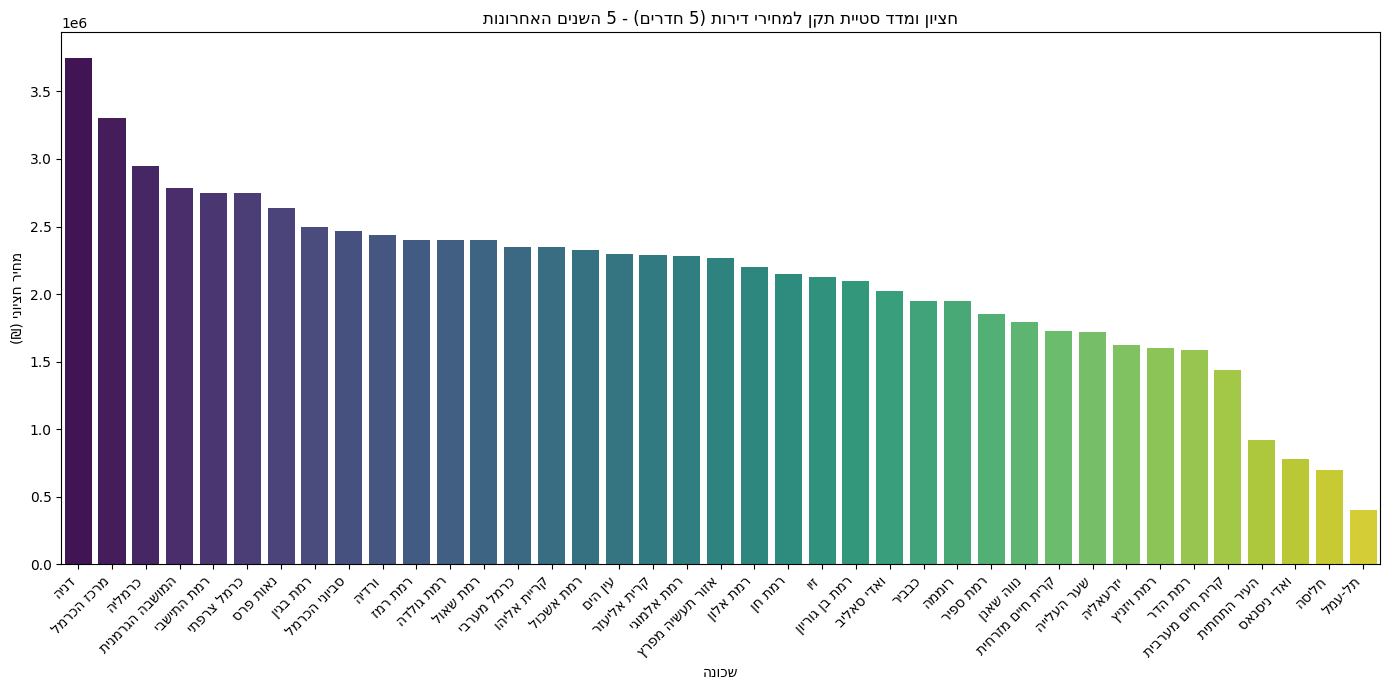

In [619]:
max_year = int(df['שנת עסקה'].max())
last_5_years = df['שנת עסקה'] >= (max_year - 4)
rooms = 5
room_filter = (df['חדרים'] == rooms) & (df['חדרים'] > 0)
filtered = df.loc[last_5_years & room_filter, ['מחיר', 'חדרים', 'שכונה']]

# --- Group and aggregate ---
agg = (
    filtered
    .groupby(['חדרים', 'שכונה'])
    .agg(median_price=('מחיר', 'median'), std_price=('מחיר', 'std'), count=('מחיר', 'count'))
    .reset_index()
)

# --- Sort by median price (optional) ---
agg = agg.sort_values('median_price', ascending=False)
# --- Fix Hebrew for neighborhood labels ---
agg['שכונה'] = agg['שכונה'].apply(fix_hebrew)

# Plot settings
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(14, 7))

# Create the barplot
ax = sns.barplot(
    data=agg,
    x='שכונה',
    y='median_price',
    hue='שכונה',
    palette='viridis',
    legend=False
)

# Rotate x labels
plt.xticks(rotation=45, ha='right')

# Set plot title and labels
plt.title(fix_hebrew(f'חציון ומדד סטיית תקן למחירי דירות ({rooms} חדרים) - 5 השנים האחרונות'))
plt.xlabel(fix_hebrew('שכונה'))
plt.ylabel(fix_hebrew('מחיר חציוני (₪)'))
plt.tight_layout()

# Add error bars manually
x_coords = np.arange(len(agg))  # Get x coordinates for error bars
# ax.errorbar(
#     x=x_coords,
#     y=agg['median_price'],
#     yerr=agg['std_price'],
#     fmt='none',  # No marker for the error bars
#     ecolor='black',  # Color of the error bars
#     capsize=5  # Caps for the error bars
# )

# Show the plot
plt.show()

### Convert Property Type to Numeric

In [620]:
df['סוג נכס'] = df['סוג נכס'].astype('category').cat.codes
df.head()

,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,1060000.0,10920-100-27,6,3.0,2,1960.0,5.0,נווה פז,0.0450,חטיבת כרמלי,21,2025,4
1,59.4,600000.0,10920-100-27,6,3.0,2,1960.0,5.0,נווה פז,0.0025,חטיבת כרמלי,21,2018,12
2,68,720000.0,12485-15-6,6,3.0,0,1940.0,3.0,נווה פז,0.0450,יד לבנים,7,2025,4
3,44.8,645000.0,12482-19-9,6,2.0,1,1960.0,3.0,נווה פז,0.0450,יד לבנים,37,2025,3
4,54,1120000.0,10925-216-9,6,3.0,3,2015.0,8.0,נווה פז,0.0450,נווה גנים,4,2025,3


### Convert Neighborhood to Numeric

In [621]:
df['שכונה'] = df['שכונה'].astype('category').cat.codes
df.head()

,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,מספר בית,שנת עסקה,חודש עסקה
0,59.4,1060000.0,10920-100-27,6,3.0,2,1960.0,5.0,17,0.0450,חטיבת כרמלי,21,2025,4
1,59.4,600000.0,10920-100-27,6,3.0,2,1960.0,5.0,17,0.0025,חטיבת כרמלי,21,2018,12
2,68,720000.0,12485-15-6,6,3.0,0,1940.0,3.0,17,0.0450,יד לבנים,7,2025,4
3,44.8,645000.0,12482-19-9,6,2.0,1,1960.0,3.0,17,0.0450,יד לבנים,37,2025,3
4,54,1120000.0,10925-216-9,6,3.0,3,2015.0,8.0,17,0.0450,נווה גנים,4,2025,3


## Create new features

In [622]:
def create_enhanced_dataset(input_df):
    """
    Take DataFrame with Hebrew columns, add advanced features, and save enhanced dataset
    
    Parameters:
    input_df (pd.DataFrame): Input DataFrame with Hebrew columns
    
    Returns:
    pd.DataFrame: Enhanced DataFrame with new features
    """
    
    print(f"Processing DataFrame with {len(input_df):,} rows")
    
    # Work with a copy to avoid modifying the original
    df = input_df.copy()
    
    # Work directly with Hebrew column names - no duplicates created
    df['מ"ר'] = pd.to_numeric(df['מ"ר'], errors='coerce')
    df['מחיר'] = pd.to_numeric(df['מחיר'], errors='coerce')
    df['חדרים'] = pd.to_numeric(df['חדרים'], errors='coerce')
    df['שנת בנייה'] = pd.to_numeric(df['שנת בנייה'], errors='coerce')
    df['קומות במבנה'] = pd.to_numeric(df['קומות במבנה'], errors='coerce')
    df['ריבית בנק ישראל'] = pd.to_numeric(df['ריבית בנק ישראל'], errors='coerce')
    df['שנת עסקה'] = pd.to_numeric(df['שנת עסקה'], errors='coerce')
    df['חודש עסקה'] = pd.to_numeric(df['חודש עסקה'], errors='coerce')
    
    # Create transaction_date from year and month columns
    print("Creating transaction dates from year/month...")
    
    # Check for invalid months
    invalid_months = df[(df['חודש עסקה'] < 1) | (df['חודש עסקה'] > 12)]['חודש עסקה'].value_counts()
    if len(invalid_months) > 0:
        print(f"Invalid months found: {invalid_months.to_dict()}")
    
    # Check for invalid years
    invalid_years = df[(df['שנת עסקה'] < 1900) | (df['שנת עסקה'] > 2030)]['שנת עסקה'].value_counts()
    if len(invalid_years) > 0:
        print(f"Invalid years found: {invalid_years.head().to_dict()}")
    
    try:
        # Method 1: Create proper DataFrame with explicit columns
        # Only use rows where both year and month are valid
        valid_date_mask = (
            df['שנת עסקה'].notna() & 
            df['חודש עסקה'].notna() & 
            (df['חודש עסקה'] >= 1) & 
            (df['חודש עסקה'] <= 12) &
            (df['שנת עסקה'] >= 1900) & 
            (df['שנת עסקה'] <= 2030)
        )
        
        # Initialize with NaT
        df['transaction_date'] = pd.NaT
        
        # Only create dates for valid combinations
        if valid_date_mask.any():
            date_df = pd.DataFrame({
                'year': df.loc[valid_date_mask, 'שנת עסקה'].astype(int),
                'month': df.loc[valid_date_mask, 'חודש עסקה'].astype(int),
                'day': 1
            })
            df.loc[valid_date_mask, 'transaction_date'] = pd.to_datetime(date_df, errors='coerce')
        
    except Exception as e:
        print(f"Method 1 failed: {e}")
        print("Trying alternative method...")
        
        # Method 2: String-based approach with validation
        df['transaction_date'] = pd.NaT
        valid_mask = (df['שנת עסקה'].notna() & df['חודש עסקה'].notna())
        
        if valid_mask.any():
            df['date_string'] = (df['שנת עסקה'].astype(str) + '-' + 
                                df['חודש עסקה'].astype(str).str.zfill(2) + '-01')
            df.loc[valid_mask, 'transaction_date'] = pd.to_datetime(
                df.loc[valid_mask, 'date_string'], format='%Y-%m-%d', errors='coerce')
            df = df.drop('date_string', axis=1)  # Clean up temporary column
    
    # Check date reconstruction
    valid_dates = df['transaction_date'].notna().sum()
    invalid_dates = df['transaction_date'].isna().sum()
    print(f"Successfully created: {valid_dates:,} dates")
    if invalid_dates > 0:
        print(f"Failed to create: {invalid_dates:,} dates")
    
    # Fill any missing dates with median
    if invalid_dates > 0:
        median_date = df['transaction_date'].median()
        df['transaction_date'] = df['transaction_date'].fillna(median_date)
        print(f"Filled {invalid_dates:,} missing dates with median")
    
    # Create basic derived features
    print("Creating basic derived features...")
    df['price_per_sqm'] = df['מחיר'] / df['מ"ר']
    df['building_age'] = 2025 - df['שנת בנייה']
    df['sqm_per_room'] = df['מ"ר'] / df['חדרים']
    df['year'] = df['transaction_date'].dt.year
    df['month'] = df['transaction_date'].dt.month
    df['year_month'] = df['year'].astype(str) + '_' + df['month'].astype(str).str.zfill(2)
    
    print("Creating advanced features...")
    
    # 1. Size vs Property Type
    property_type_avg_sqm = df.groupby('סוג נכס')['מ"ר'].transform('mean')
    df['size_vs_property_type'] = df['מ"ר'] - property_type_avg_sqm
    
    # 2. Size vs Neighborhood
    neighborhood_sqm_mean = df.groupby('שכונה')['מ"ר'].transform('mean')
    df['size_vs_neighborhood'] = df['מ"ר'] - neighborhood_sqm_mean
    
    # 3. Price vs Neighborhood Median
    neighborhood_price_median = df.groupby('שכונה')['price_per_sqm'].transform('median')
    df['price_vs_neighborhood_median'] = ((df['price_per_sqm'] - neighborhood_price_median) / 
                                          neighborhood_price_median)
    
    # 4. Building Age vs Neighborhood Average
    neighborhood_age_mean = df.groupby('שכונה')['building_age'].transform('mean')
    df['building_age_vs_neighborhood'] = df['building_age'] - neighborhood_age_mean
    
    # 5. Interest Rate Deviation (12-month lookback)
    print("Calculating 12-month interest rate deviation...")
    
    df_sorted = df.sort_values('transaction_date').copy()
    df_sorted = df_sorted.set_index('transaction_date')
    
    # Rolling calculation
    df_sorted['rate_12m_avg'] = df_sorted['ריבית בנק ישראל'].rolling(
        window='365D', min_periods=30).mean().shift(1)
    
    df_sorted['interest_rate_deviation'] = df_sorted['ריבית בנק ישראל'] - df_sorted['rate_12m_avg']
    
    # Reset index and merge back
    df_sorted = df_sorted.reset_index()
    df = df_sorted.copy()
    
    # Clean up intermediate columns we no longer need
    columns_to_drop = ['transaction_date', 'year', 'month', 'year_month', 'rate_12m_avg']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Final cleanup - only drop rows where critical fields are missing
    critical_fields = ['מחיר', 'מ"ר', 'שכונה']  # Using Hebrew column names
    before_critical_clean = len(df)
    df = df.dropna(subset=critical_fields)
    after_critical_clean = len(df)
    
    if before_critical_clean != after_critical_clean:
        print(f"Removed {before_critical_clean - after_critical_clean:,} rows missing critical data")
    
    # Summary
    new_features = [
        'size_vs_property_type', 'size_vs_neighborhood', 'price_vs_neighborhood_median',
        'building_age_vs_neighborhood', 'interest_rate_deviation'
    ]
    
    print(f"Final dataset: {len(df):,} rows")
    print(f"Total features: {len(df.columns)} columns")
    print(f"Added features: {len(new_features)}")
    
    return df

In [623]:
df = create_enhanced_dataset(df)
df.head()

Processing DataFrame with 45,184 rows
Creating transaction dates from year/month...
Successfully created: 45,184 dates
Creating basic derived features...
Creating advanced features...
Calculating 12-month interest rate deviation...
Final dataset: 45,184 rows
Total features: 22 columns
Added features: 5


,"מ""ר",מחיר,גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,...,שנת עסקה,חודש עסקה,price_per_sqm,building_age,sqm_per_room,size_vs_property_type,size_vs_neighborhood,price_vs_neighborhood_median,building_age_vs_neighborhood,interest_rate_deviation
0,82.50,614000.0,11215-10-26,6,4.0,2,1970.0,8.0,10,0.134,...,1998,1,7442.424242,55.0,20.6250,0.056076,14.237213,-0.420119,0.520278,NaN
1,51.00,355000.0,11720-16-11,6,2.0,3,1960.0,3.0,41,0.134,...,1998,1,6960.784314,65.0,25.5000,-31.443924,-11.740919,-0.261383,8.674632,NaN
2,119.20,888000.0,10797-45-2,9,5.0,1,1970.0,2.0,1,0.134,...,1998,1,7449.664430,55.0,23.8400,9.137565,-101.038471,-0.506701,16.353719,NaN
3,94.96,1103000.0,10761-18-2,6,4.0,1,1970.0,4.0,14,0.134,...,1998,1,11615.417018,55.0,23.7400,12.516076,-19.331597,-0.329399,6.763305,NaN
4,94.99,519000.0,11576-50-7,6,4.0,3,1980.0,3.0,24,0.129,...,1998,1,5463.733025,45.0,23.7475,12.546076,0.946537,-0.546138,2.005488,NaN


## Normalize price according to CPI

In [628]:
# Load housing index data
file_path = "./data/gov/housing_index_by_month.csv"
df_index = pd.read_csv(file_path)

# Pick the base index (year and month you want to normalize to)
BASE_YEAR = 2025
BASE_MONTH = 1

# Calculate normalized prices
# Normalized Price = Original Price * (Base Index / Transaction Index)
base_index_value = df_index.query("שנה == @BASE_YEAR and חודש == @BASE_MONTH")['מדד דיור'].values[0]

# Create a lookup dictionary: (Year, Month) -> Index
index_lookup = {
    (row['שנה'], row['חודש']): row['מדד דיור'] for _, row in df_index.iterrows()
}

# Calculate Normalized_Price without adding a new column for Housing_Index
def normalize_price(row):
    trans_index = index_lookup.get((row['שנת עסקה'], row['חודש עסקה']))
    if pd.isna(trans_index) or trans_index == 0:
        return None
    raw_price = row['מחיר'] * (base_index_value / trans_index)
    return round(raw_price)

df['Normalized_Price'] = df.apply(normalize_price, axis=1)
df = df.drop(columns=['מחיר'])
df.head()

,"מ""ר",גוש/חלקה/תת-חלקה,סוג נכס,חדרים,קומה,שנת בנייה,קומות במבנה,שכונה,ריבית בנק ישראל,רחוב,...,חודש עסקה,price_per_sqm,building_age,sqm_per_room,size_vs_property_type,size_vs_neighborhood,price_vs_neighborhood_median,building_age_vs_neighborhood,interest_rate_deviation,Normalized_Price
0,82.50,11215-10-26,6,4.0,2,1970.0,8.0,10,0.134,קליבנוב,...,1,7442.424242,55.0,20.6250,0.056076,14.237213,-0.420119,0.520278,NaN,1961201.0
1,51.00,11720-16-11,6,2.0,3,1960.0,3.0,41,0.134,פאר,...,1,6960.784314,65.0,25.5000,-31.443924,-11.740919,-0.261383,8.674632,NaN,1133919.0
2,119.20,10797-45-2,9,5.0,1,1970.0,2.0,1,0.134,אבא חושי,...,1,7449.664430,55.0,23.8400,9.137565,-101.038471,-0.506701,16.353719,NaN,2836396.0
3,94.96,10761-18-2,6,4.0,1,1970.0,4.0,14,0.134,חנה,...,1,11615.417018,55.0,23.7400,12.516076,-19.331597,-0.329399,6.763305,NaN,3523136.0
4,94.99,11576-50-7,6,4.0,3,1980.0,3.0,24,0.129,משה שרת,...,1,5463.733025,45.0,23.7475,12.546076,0.946537,-0.546138,2.005488,NaN,1657758.0


## Split Data into Features (X) and Target (y)

In [630]:
# Define target and features
y = df['Normalized_Price']
X = df.drop(columns=['Normalized_Price'])

## Correlation between Features and Target

In [631]:
# Calculate correlations
correlations = pd.concat([X, y], axis=1).corr(numeric_only=True)['Normalized_Price'].sort_values(ascending=False)
print(correlations)

Normalized_Price                1.000000
מ"ר                             0.476075
חדרים                           0.467248
size_vs_neighborhood            0.420645
size_vs_property_type           0.420523
price_per_sqm                   0.372200
price_vs_neighborhood_median    0.362043
סוג נכס                         0.197915
שנת בנייה                       0.172105
sqm_per_room                    0.166548
ריבית בנק ישראל                 0.025817
חודש עסקה                      -0.001369
קומות במבנה                    -0.009103
קומה                           -0.018151
interest_rate_deviation        -0.036500
מספר בית                       -0.048825
שנת עסקה                       -0.068625
building_age_vs_neighborhood   -0.078094
שכונה                          -0.108798
building_age                   -0.172105
Name: Normalized_Price, dtype: float64


## Train-Test Split

In [632]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (36147, 21)
Test shape: (9037, 21)
